In [1]:
import pandas as pd
import numpy as np
import os
import keras


%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Model
from keras import layers
from keras import Input
from sklearn.metrics import confusion_matrix,roc_curve, auc,recall_score,precision_score,f1_score
from keras.utils.vis_utils import plot_model

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-02-27 17:30:44.394705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 参数设置

In [3]:
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False


# from tensorflow import losses
daily_back=20
wenben_back=10
total_day=2159 #根据查看数据表，得到数值
train_num=1650



wenben_sort=2
batch_size=8
epochs=20
LSTM_num=100
dense_num=20


mix_file='daily_data.xlsx'
first_columns='search_index'



test_num=total_day-train_num

# 数据转换类，返回多个字典？

In [6]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.wenben_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target']
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

# 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [8]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back)


# 读取原始数据

In [10]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'

# wenben_dir='/Users/ccmac/Documents/毕业论文数据/每日均值'
daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 历史数据标准化函数norm

In [12]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 文本数据标准化函数wenben_norm

In [14]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)
    # media_attention_mean_value = df['media_attention'].mean(axis=0)


    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()
    # media_attention_std_value = df['media_attention'].std()


    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    # x['media_attention'] = (df['media_attention'] - media_attention_mean_value) / media_attention_std_value

    df=x
    return df

# 数据切分

In [16]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

# 进行数据切分

In [18]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1650, 8)
日频测试切分： (509, 8)
十五分钟频训练切分： (26400, 6)
十五分钟频测试切分： (8320, 6)
训练目标切分： (1650, 2)
测试目标切分： (520, 2)


# 调用类中的方法,处理原始数据

In [20]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)

wenben_train=DM.wenben_train_data(wenben_norm_train_df)

wenben_test=DM.wenben_test_data(wenben_norm_test_df)


(1630, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649],
      dtype='int64', length=1650)
日频训练array： (1630, 20, 5)
509 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_61175/3624395069.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == j, 'target']
/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_61175/3624395069.py:116: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j


(489,)
文本长期训练array： (1630, 10, 2)
长期文本测试array： (489, 10, 2)


# 构建神经网络模型

In [22]:
def my_model(wenben_back,wenben_sort):

    ##### 一、模型搭建

    # 文本输入训练(!!!卷积滤镜行列先后)
    wenben_input=Input(shape=(wenben_back,wenben_sort),dtype='float32',name='wenben_input')
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(wenben_input)
    LSTM_wenben=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 15分钟频输入训练(!!!卷积滤镜行列先后)
    fif_min_input=Input(shape=(16,5),dtype='float32',name='fif_min_input')
    # fif_min_input=(8,16,4,1)
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(fif_min_input)
    LSTM_fif=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 日频输入训练
    daily_input=Input(shape=(20,5),dtype='float32',name='daily_input')
    # daily_input=(8,16,4,1)
    Conv1D_daily=layers.Conv1D(16,1,strides=1)(daily_input)
    LSTM_daily=layers.LSTM(LSTM_num)(Conv1D_daily)
    # 15分钟频训练结果和日频训练结果合并
    concatenated=layers.concatenate([LSTM_fif,LSTM_daily,LSTM_wenben],axis=-1) # axis=-1按照最后一个轴粘合

    alloy=layers.Dense(dense_num,activation='relu')(concatenated) #将粘合结果再接一个全连接层
    dropout=layers.Dropout(0.2)(alloy)
    output=layers.Dense(1,activation='sigmoid')(dropout)
    model=Model([fif_min_input,daily_input,wenben_input],output) #八股文：将输入和输出圈起来

    print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])
    return model
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')


# 模型滞后时长赋值

In [24]:
model=my_model(wenben_back=wenben_back,wenben_sort=wenben_sort)


2025-02-27 17:30:51.507801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:30:51.508473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:30:51.509339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fif_min_input (InputLayer)     [(None, 16, 5)]      0           []                               
                                                                                                  
 daily_input (InputLayer)       [(None, 20, 5)]      0           []                               
                                                                                                  
 wenben_input (InputLayer)      [(None, 10, 2)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 16, 16)       96          ['fif_min_input[0][0]']          
                                                                                              

2025-02-27 17:30:51.739537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:30:51.740183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:30:51.740964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# 添加输出模型参数的代码块

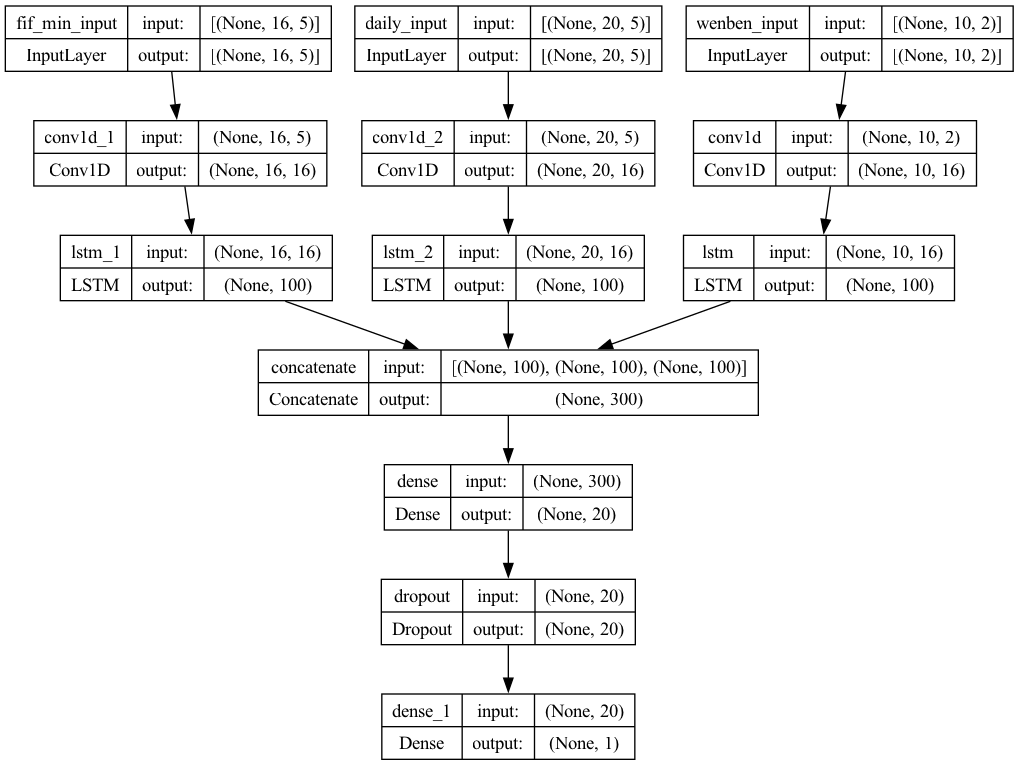

In [26]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# model.fit(输入自变量x，因变量y)

In [28]:
history=model.fit(x=[fif_train,daily_train,wenben_train],y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/20


2025-02-27 17:30:52.235631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:30:52.236372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:30:52.237424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

149/153 [============================>.] - ETA: 0s - loss: 0.7001 - acc: 0.5277

2025-02-27 17:30:55.501272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:30:55.502189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:30:55.502826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 4s 11ms/step - loss: 0.7009 - acc: 0.5245 - val_loss: 0.7129 - val_acc: 0.4877
Epoch 2/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6919 - acc: 0.5434 - val_loss: 0.7206 - val_acc: 0.4902
Epoch 3/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6887 - acc: 0.5442 - val_loss: 0.7252 - val_acc: 0.4902
Epoch 4/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6903 - acc: 0.5360 - val_loss: 0.7045 - val_acc: 0.5074
Epoch 5/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6877 - acc: 0.5409 - val_loss: 0.7138 - val_acc: 0.4926
Epoch 6/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6848 - acc: 0.5417 - val_loss: 0.7368 - val_acc: 0.4926
Epoch 7/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6859 - acc: 0.5450 - val_loss: 0.7192 - val_acc: 0.4926
Epoch 8/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6822 - acc

# model.evaluate(输入测试数据)，进行模型预测性能测试

In [30]:
loss,accuracy = model.evaluate([fif_test,daily_test,wenben_test],y=target_test)
print(loss,accuracy)

2025-02-27 17:31:16.544059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:31:16.544734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:31:16.545448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 4ms/step - loss: 0.7341 - acc: 0.5378
0.7340624332427979 0.5378323197364807


# 构建y的函数

In [32]:
def gen_y_pred():
    y_predict=model.predict([fif_test,daily_test,wenben_test],batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [34]:
y_pred=gen_y_pred()
print(y_pred)

2025-02-27 17:31:17.227481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:31:17.228446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:31:17.229089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/489 [..............................] - ETA: 4:16

2025-02-27 17:31:17.432172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:31:17.432831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:31:17.433569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

489/489 [==============================] - 1s 1ms/step
[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#  构建使用测试集作为回测数据的类

In [36]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back,wenben_back):
        self.train_num=train_num
        self.daily_back=daily_back
        self.wenben_back = wenben_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.wenben_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [38]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20,wenben_back=daily_back)

# 

In [40]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [41]:
back_df=split_back_trader()['daily_test_df']

In [42]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1650,2022-11-03,2981.20,3003.72,2977.72,2997.81,259348567,261656,-0.804520
1651,2022-11-04,2997.00,3081.59,2997.00,3070.80,329806740,250605,-0.663122
1652,2022-11-07,3062.86,3088.19,3054.46,3077.82,320567097,255756,-0.706624
1653,2022-11-08,3077.31,3078.28,3047.46,3064.49,256522007,235956,-0.746056
1654,2022-11-09,3064.46,3073.92,3046.19,3048.17,235637324,229434,-0.947768
...,...,...,...,...,...,...,...,...
2154,2024-12-02,3328.48,3369.30,3323.01,3363.98,668477762,428407,-0.647137
2155,2024-12-03,3366.29,3386.62,3348.37,3378.81,663030139,438283,-0.861024
2156,2024-12-04,3376.57,3388.02,3352.94,3364.65,621028862,425902,-0.984183
2157,2024-12-05,3353.06,3377.06,3353.06,3368.86,543885746,397751,-0.812990


In [43]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659,
       ...
       2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158],
      dtype='int64', length=509)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [45]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+20+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+20+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

488
         open    close  rate_of_return  day_rate_of_return
1671  3160.58  3156.14       -0.002947           -0.001405
1672  3181.92  3211.81        0.017639            0.009394
1673  3200.28  3212.53        0.000224            0.003828
1674  3204.94  3199.62       -0.004019           -0.001660
1675  3196.02  3197.35       -0.000709            0.000416
...       ...      ...             ...                 ...
2154  3328.48  3363.98        0.011279            0.010666
2155  3366.29  3378.81        0.004408            0.003719
2156  3376.57  3364.65       -0.004191           -0.003530
2157  3353.06  3368.86        0.001251            0.004712
2158  3370.94  3404.08        0.010455            0.009831

[488 rows x 4 columns]
         open    close  rate_of_return  day_rate_of_return  last_close  \
1670  3187.99  3165.47             NaN           -0.007064         NaN   
1671  3160.58  3156.14       -0.002947           -0.001405     3165.47   
1672  3181.92  3211.81        0.017639    

# 回测交易逻辑

In [47]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+20 + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+20 + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+20 + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [48]:
result=backtrader(y_pred,backtrader_df)
print(result[1])
print(result[2])
print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


[0.009393699401619049, 0.0002241726627665308, -0.002362623850983514, -0.0009781596759178557, 6.296574978059688e-05, -0.002480694342568812, -0.0039512095056254415, 0.005695164359293958, 0.003976434974360288, 0.0015367058731992067, 0.00882088267093084, 0.0022493109279289047, 0.010148806474746364, -4.754026660569455e-05, -0.005963401506996702, 0.011840562357098072, -0.0029690739302467017, -0.0011286024038005271, -0.006382657416795889, 0.002000607936675225, 0.012570784233547627, -0.00715574999235169, 0.005546465514850718, -0.00577327927778859, 0.001630069701657133, 0.0010398240297795347, 0.0007170413769646, -0.0021342723723493107, -0.0031945355660336627, -0.0018515101187180916, -0.0016392533385921615, 0.006540002345635676, 0.000662322729015008, 0.004664592166639503, 2.113169270900883e-05, 0.004534161678183102, -0.003693297071506896, 0.0005187973553399949, 0.0035413979803811113, -0.00032652816679901164, -0.006257095257050982, -0.0009198458219712435, -0.019533535489734244, -0.007830343565790

In [49]:
returns=result[3]
returns = [ret - 1 for ret in returns]
returns

[0.009393699401619049,
 0.00961997787499369,
 0.007234625634836789,
 0.006249389339852529,
 0.006312748587118611,
 0.0038163942448437016,
 -0.00014989463399917025,
 0.005544416050717649,
 0.009542898034974323,
 0.011094268535631224,
 0.02001301244763476,
 0.02230733886316294,
 0.032682538202998046,
 0.032633444199812844,
 0.026475436362496385,
 0.03862948277477596,
 0.03554571505428372,
 0.03437699567102803,
 0.027774921667845343,
 0.029831096333249763,
 0.04277688084225284,
 0.03531503018514126,
 0.04105736929706971,
 0.03504705435991773,
 0.03673425320301926,
 0.037812274391995304,
 0.03855642873425613,
 0.03633986644128284,
 0.033029241879437565,
 0.031116577785166077,
 0.029426316492554117,
 0.036158767017074434,
 0.03684503851933796,
 0.04168149776403429,
 0.041703510257345755,
 0.046426762393583454,
 0.04256199749648881,
 0.04310287590356787,
 0.04679691832162258,
 0.04645510964287225,
 0.039907340339609076,
 0.038950785917360564,
 0.018656403868556604,
 0.010679974250773494,
 0.

In [50]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -105.65%


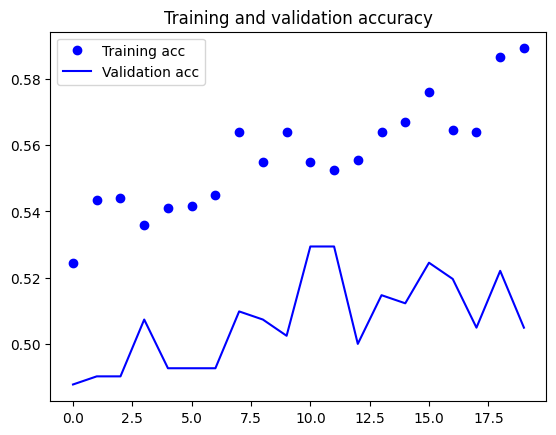

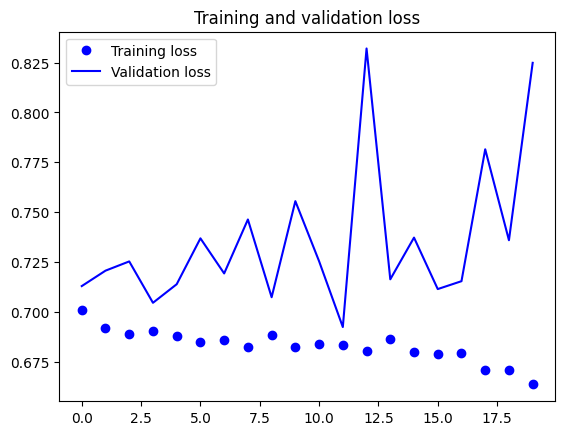

In [51]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [53]:
confusion_matrix = confusion_matrix(target_test, y_pred,labels=[1,0])
precision_score=precision_score(target_test, y_pred)
recall_score=recall_score(target_test, y_pred)
f1_score=f1_score(target_test, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[120 118]
 [108 143]]
查准率： 0.5263157894736842
查全率： 0.5042016806722689
f1-score: 0.5150214592274679


2025-02-27 17:31:18.832361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:31:18.833032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:31:18.833751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/16 [>.............................] - ETA: 7s

2025-02-27 17:31:19.039856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-27 17:31:19.040539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-27 17:31:19.041318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 4ms/step


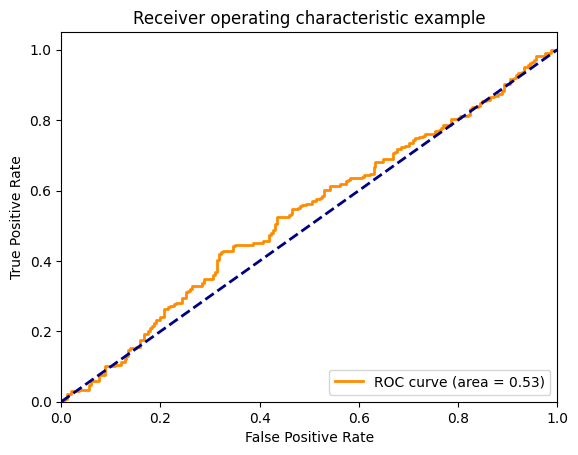

In [54]:
y_predict=model.predict([fif_test,daily_test,wenben_test]).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [56]:
df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
df10=pd.DataFrame({'每日收益率':result[1]})
path9='/Users/ccmac/Desktop'
df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [57]:
import numpy as np
t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
y = np.cumprod(t, axis=1)
print(t)
print(y)


[[1 2 3 4]
 [5 6 7 8]]
[[   1    2    6   24]
 [   5   30  210 1680]]
